# Python Sales Forecasting with AI Based - Daily Forecasting
This code documentation and code is written by Recep Barkın Topcu.

The dataset is taken from kaggle: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

This code just focus on the company transaction without store based. All sales of the all stores at each day are gathered together.

# Data Preprocessing

These part are already done in D00. However, I will show you again.

In [1]:
pip install modin[ray] -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.8 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#modin pandas is faster than pandas
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [4]:
#Dask is used for reading the csv. When I was using pandas in the other projects sometimes pandas cannot read all of the data. For that reason I prefer to use dask.
sales_df = dd.read_csv("transactions.csv")
sales_df = sales_df.compute()
sales_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [5]:
sales_df.drop(index=0,inplace=True) #There is only one sales info at 2013-01-01. I am deleting this data because of that.
sales_df["date"] = pd.to_datetime(sales_df["date"]) #Converting date column to datetime format
#Gathering all transactions of the all stores for each day.
sales_df = sales_df.groupby("date",as_index=False).agg({"transactions":"sum"})
#I added some columns for deep learning and machine learning techniques.
#Firstly, national holidays are added.
holidays_df = dd.read_csv("holidays_events.csv")
holidays_df = holidays_df.compute()
holidays_df.drop(columns=["type","locale_name","description","transferred"],inplace=True)
holidays_df = holidays_df[holidays_df['locale'] == 'National']
sales_df['is_holiday'] = sales_df['date'].isin(holidays_df['date']).astype(int)
#Here, I added a column to the table that contains the average up to a specific day in the past
for window in [3, 7, 30]:
    sales_df[f'past_rolling_mean_{window}'] = sales_df['transactions'].rolling(window).mean().shift(1)

#Creating lags
for lag in range(1, 61):
    sales_df[f'lag_{lag}'] = sales_df['transactions'].shift(lag)

#Seperating date to year, month and day
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
sales_df['day'] = sales_df['date'].dt.day

In [6]:
sales_df.dropna(inplace=True)
sales_df

,date,transactions,is_holiday,past_rolling_mean_3,past_rolling_mean_7,past_rolling_mean_30,lag_1,lag_2,lag_3,lag_4,...,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,year,month,day
60,2013-03-03,92716,0,82652.666667,77589.428571,78258.500000,98616.0,79524.0,69818.0,70170.0,...,72325.0,75597.0,90464.0,93573.0,78494.0,78504.0,93215.0,2013,3,3
61,2013-03-04,79078,0,90285.333333,78816.714286,78738.966667,92716.0,98616.0,79524.0,69818.0,...,71971.0,72325.0,75597.0,90464.0,93573.0,78494.0,78504.0,2013,3,4
62,2013-03-05,75134,0,90136.666667,79804.000000,78130.000000,79078.0,92716.0,98616.0,79524.0,...,66383.0,71971.0,72325.0,75597.0,90464.0,93573.0,78494.0,2013,3,5
63,2013-03-06,76519,0,82309.333333,80722.285714,77733.600000,75134.0,79078.0,92716.0,98616.0,...,70338.0,66383.0,71971.0,72325.0,75597.0,90464.0,93573.0,2013,3,6
64,2013-03-07,73910,0,76910.333333,81629.285714,77773.233333,76519.0,75134.0,79078.0,92716.0,...,85511.0,70338.0,66383.0,71971.0,72325.0,75597.0,90464.0,2013,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,2017-08-11,89551,1,83979.333333,89655.000000,88652.166667,83064.0,85452.0,83422.0,87072.0,...,99193.0,114201.0,92852.0,81831.0,82752.0,81063.0,81080.0,2017,8,11
1677,2017-08-12,89927,0,86022.333333,89404.428571,88832.033333,89551.0,83064.0,85452.0,83422.0,...,82891.0,99193.0,114201.0,92852.0,81831.0,82752.0,81063.0,2017,8,12
1678,2017-08-13,85993,0,87514.000000,87807.142857,89205.600000,89927.0,89551.0,83064.0,85452.0,...,83508.0,82891.0,99193.0,114201.0,92852.0,81831.0,82752.0,2017,8,13
1679,2017-08-14,85448,0,88490.333333,86354.428571,89149.666667,85993.0,89927.0,89551.0,83064.0,...,82929.0,83508.0,82891.0,99193.0,114201.0,92852.0,81831.0,2017,8,14


# Method 1

In this method, the data set is splitted as %70 Train, %15 Validation, and %15 Test Sets. The purpose of this method is forecasting to next days.

For example:

The train set is include 01.01.16 to 31.01.16 Validation is similar with fewer.
The test set will be like 10.02.17 to 17.02.17.

In [7]:
data_len = len(sales_df)
train_end = int(data_len * 0.7)
val_end = int(data_len * 0.85)  # %70 + %15 = %85
"""The reason for that there could be data loss between data sets
because we are multiplying with double and rooling to int.

Otherwise, train_end can be 105 and val_start can be 107(example)
(the problem generally occur in multiple in 10)
"""

'The reason for that there could be data loss between data sets\nbecause we are multiplying with double and rooling to int.\n\nOtherwise, train_end can be 105 and val_start can be 107(example)\n(the problem generally occur in multiple in 10)\n'

In [8]:
train_df = sales_df.iloc[:train_end]
val_df = sales_df.iloc[train_end:val_end]
test_df = sales_df.iloc[val_end:]

In [9]:
print(f"Data:{len(sales_df)}, Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)},Check = {len(train_df)+len(val_df)+len(test_df)}")

Data:1621, Train: 1134, Validation: 243, Test: 244,Check = 1621


In [10]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
seq_length = 20
X_train, y_train = create_sequences(train_df['transactions'].values, seq_length)
X_val, y_val = create_sequences(val_df['transactions'].values, seq_length)
X_test, y_test = create_sequences(test_df['transactions'].values, seq_length)

In [12]:
X_train

array([[92716, 79078, 75134, ..., 74145, 69157, 71990],
       [79078, 75134, 76519, ..., 69157, 71990, 91923],
       [75134, 76519, 73910, ..., 71990, 91923, 83439],
       ...,
       [82331, 86834, 78832, ..., 97454, 91977, 77860],
       [86834, 78832, 91232, ..., 91977, 77860, 82484],
       [78832, 91232, 82305, ..., 77860, 82484, 79657]])

In [13]:
y_train

array([91923, 83439, 72992, ..., 82484, 79657, 74291])

In [14]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

In [15]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.fit_transform(y_val.reshape(-1, 1))

In [16]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# LSTM Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

In [18]:
model_LSTM_simple = Sequential([
    LSTM(32, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
model_LSTM_simple.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_simple = model_LSTM_simple.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.9269 - mae: 0.7177 - val_loss: 0.9978 - val_mae: 0.8240
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8192 - mae: 0.6864 - val_loss: 0.9940 - val_mae: 0.8247
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8715 - mae: 0.6785 - val_loss: 0.9905 - val_mae: 0.8250
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9360 - mae: 0.6982 - val_loss: 0.9844 - val_mae: 0.8224
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8696 - mae: 0.6632 - val_loss: 0.9762 - val_mae: 0.8202
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9647 - mae: 0.6666 - val_loss: 0.9656 - val_mae: 0.8117
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1112 - mae: 0.6888 - val_loss: 0.9600 - val_mae: 0.8088
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7280 - mae: 0.6203 - val_loss: 0.9419 - val_mae: 0.7936
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1

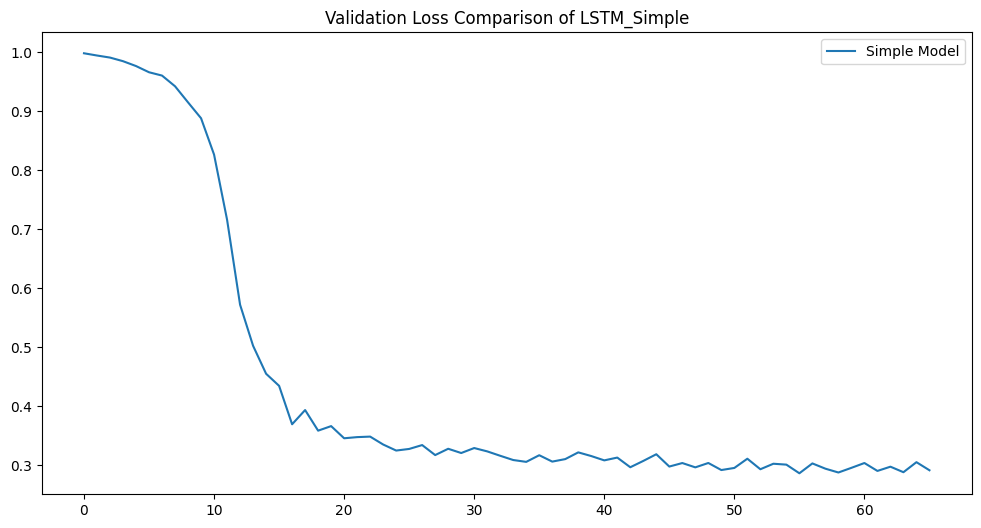

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_simple.history['val_loss'], label='Simple Model')
plt.legend()
plt.title('Validation Loss Comparison of LSTM_Simple')
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
y_pred_scaled = model_LSTM_simple.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_lstm_simple = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_lstm_simple = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_lstm_simple = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_lstm_simple} \n RMSE is {rmse_lstm_simple} \n MAPE is {mape_lstm_simple}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
R^2 is 0.5016293525695801 
 RMSE is 6053.291005725729 
 MAPE is 0.048875052481889725


In [21]:
#Creating a new dataframe to compare the methods in the end.
result_data = {"Method":["LSTM - Simple"],
               "R^2":[r2_lstm_simple],
               "RMSE":[rmse_lstm_simple],
               "MAPE":[mape_lstm_simple]}
results_df = pd.DataFrame(data=result_data)
results_df

2025-03-22 11:59:57,879	INFO worker.py:1852 -- Started a local Ray instance.


,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875


In [22]:
from tensorflow.keras.regularizers import l2
model_LSTM_normal = Sequential([
    LSTM(64,input_shape=(X_train_scaled.shape[1],1),kernel_regularizer=l2(0.001),return_sequences=False),
    Dropout(0.2),
    Dense(32,activation="relu",kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_LSTM_normal.compile(optimizer="adam",loss="mae")

history_simple = model_LSTM_normal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

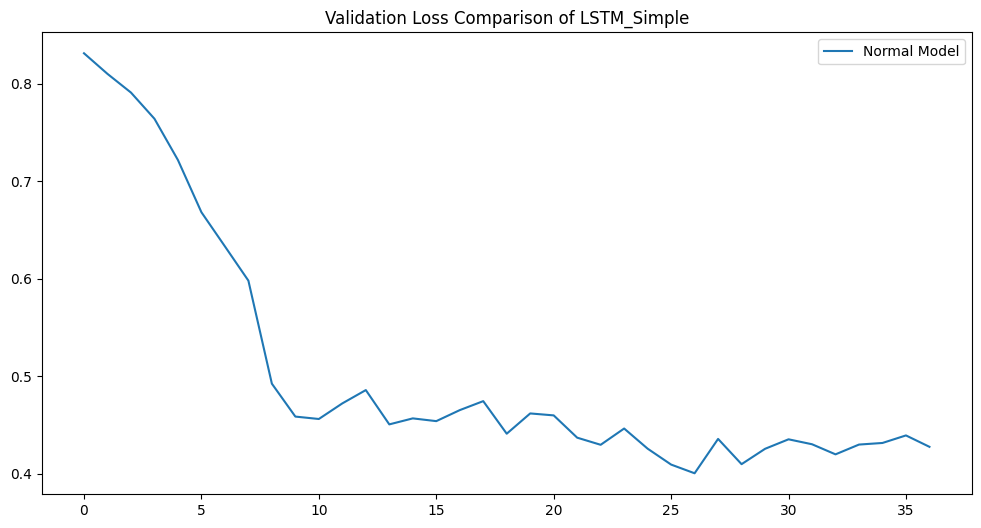

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_simple.history['val_loss'], label='Normal Model')
plt.legend()
plt.title('Validation Loss Comparison of LSTM_Simple')
plt.show()

In [24]:
y_pred_scaled = model_LSTM_normal.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_lstm_normal = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_lstm_normal = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_lstm_normal = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_lstm_normal} \n RMSE is {rmse_lstm_normal} \n MAPE is {mape_lstm_normal}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
R^2 is 0.5498793125152588 
 RMSE is 5752.806967037917 
 MAPE is 0.044030528515577316


In [25]:
result_data = {"Method":["LSTM - Normal"],
               "R^2":[r2_lstm_normal],
               "RMSE":[rmse_lstm_normal],
               "MAPE":[mape_lstm_normal]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031


In [26]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [27]:
model_LSTM_advanced = Sequential([
    Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l2(0.001),
                       recurrent_dropout=0.2),
                  input_shape=(X_train_scaled.shape[1],1)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False,
                       kernel_regularizer=l2(0.001),
                       recurrent_dropout=0.2)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(1)
])

In [28]:
model_LSTM_advanced.compile(optimizer="adam",loss="mae")

history_simple = model_LSTM_advanced.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - loss: 1.7186 - val_loss: 1.4057
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - loss: 1.5555 - val_loss: 1.3894
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - loss: 1.3841 - val_loss: 1.3671
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 1.3683 - val_loss: 1.3466
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - loss: 1.2300 - val_loss: 1.3244
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - loss: 1.2304 - val_loss: 1.3311
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - loss: 1.1485 - val_loss: 1.3192
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - loss: 1.1325 - val_loss: 1.2921
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 1.0362 - val_loss: 1.2586
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - loss: 1.0734 - val_loss: 1.2323
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - loss: 0.9962 - val_loss: 1.1964
Epoch 12/100
35/35 ━━━━━━━━━━━━━

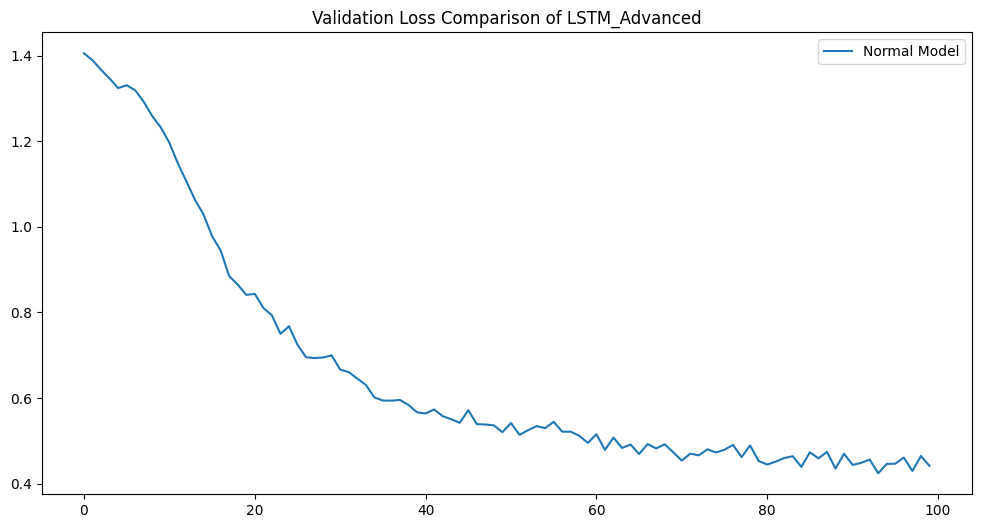

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_simple.history['val_loss'], label='Normal Model')
plt.legend()
plt.title('Validation Loss Comparison of LSTM_Advanced')
plt.show()

In [30]:
y_pred_scaled = model_LSTM_advanced.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_lstm_advanced = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_lstm_advanced = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_lstm_advanced = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_lstm_advanced} \n RMSE is {rmse_lstm_advanced} \n MAPE is {mape_lstm_advanced}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
R^2 is 0.5656347274780273 
 RMSE is 5651.228892904622 
 MAPE is 0.04177210479974747


In [31]:
result_data = {"Method":["LSTM - Advance"],
               "R^2":[r2_lstm_advanced],
               "RMSE":[rmse_lstm_advanced],
               "MAPE":[mape_lstm_advanced]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772


# RNN

In [32]:
from tensorflow.keras.layers import SimpleRNN

In [33]:
model_RNN_simple = Sequential([
    SimpleRNN(32, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
model_RNN_simple.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
history_rnn = model_RNN_simple.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.8337 - mae: 0.5940 - val_loss: 0.3314 - val_mae: 0.4440
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5676 - mae: 0.4185 - val_loss: 0.3144 - val_mae: 0.4349
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5095 - mae: 0.3846 - val_loss: 0.3277 - val_mae: 0.4466
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4782 - mae: 0.3907 - val_loss: 0.2934 - val_mae: 0.4197
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4694 - mae: 0.3788 - val_loss: 0.3119 - val_mae: 0.4335
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3915 - mae: 0.3598 - val_loss: 0.3118 - val_mae: 0.4378
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4212 - mae: 0.3667 - val_loss: 0.2821 - val_mae: 0.4034
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6724 - mae: 0.4034 - val_loss: 0.2834 - val_mae: 0.4103
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2961 - mae: 0

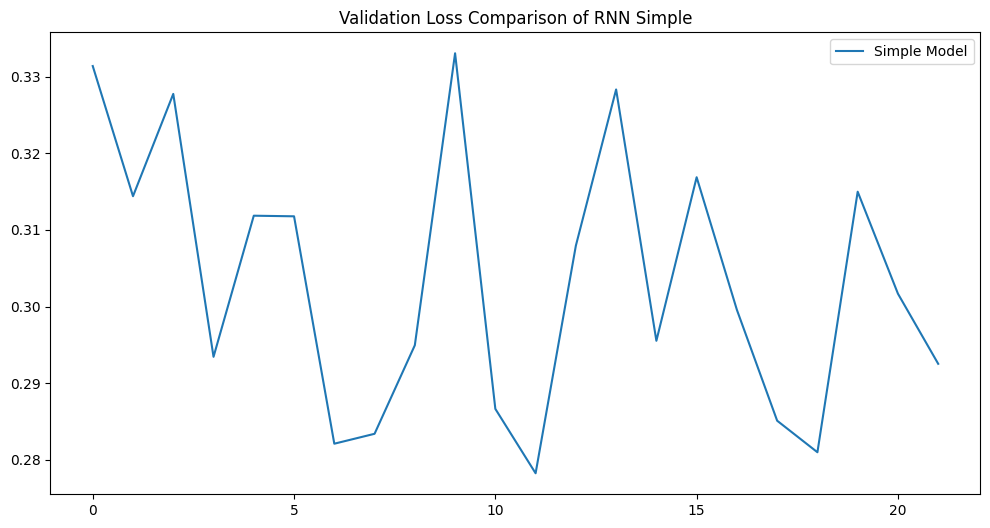

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_rnn.history['val_loss'], label='Simple Model')
plt.legend()
plt.title('Validation Loss Comparison of RNN Simple')
plt.show()

In [35]:
y_pred_scaled = model_RNN_simple.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_rnn_simple = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_rnn_simple = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_rnn_simple = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_rnn_simple} \n RMSE is {rmse_rnn_simple} \n MAPE is {mape_rnn_simple}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
R^2 is 0.5858817100524902 
 RMSE is 5517.947082022443 
 MAPE is 0.04397004842758179


In [36]:
result_data = {"Method":["RNN - Simple"],
               "R^2":[r2_rnn_simple],
               "RMSE":[rmse_rnn_simple],
               "MAPE":[mape_rnn_simple]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772
3,RNN - Simple,0.585882,5517.947082,0.043970


In [37]:
model_RNN_normal = Sequential([
    SimpleRNN(64, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_RNN_normal.compile(optimizer="adam", loss="mae")

history_rnn = model_RNN_normal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

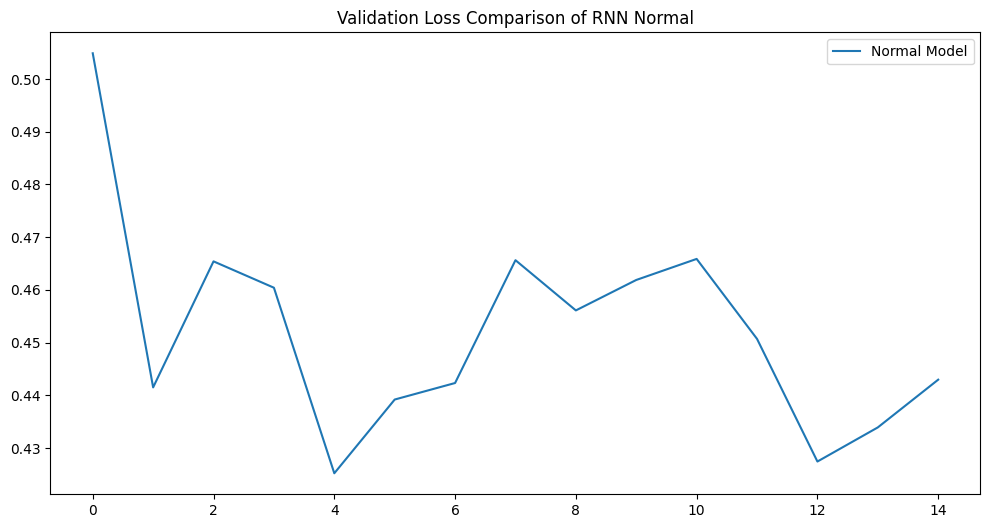

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_rnn.history['val_loss'], label='Normal Model')
plt.legend()
plt.title('Validation Loss Comparison of RNN Normal')
plt.show()

In [39]:
y_pred_scaled = model_RNN_normal.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_rnn_normal = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_rnn_normal = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_rnn_normal = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_rnn_normal} \n RMSE is {rmse_rnn_normal} \n MAPE is {mape_rnn_normal}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
R^2 is 0.5621967911720276 
 RMSE is 5673.548801235432 
 MAPE is 0.044368889182806015


In [40]:
result_data = {"Method":["RNN - Normal"],
               "R^2":[r2_rnn_normal],
               "RMSE":[rmse_rnn_normal],
               "MAPE":[mape_rnn_normal]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772
3,RNN - Simple,0.585882,5517.947082,0.043970
4,RNN - Normal,0.562197,5673.548801,0.044369


In [41]:
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772
3,RNN - Simple,0.585882,5517.947082,0.043970
4,RNN - Normal,0.562197,5673.548801,0.044369


In [42]:
model_RNN_advance = Sequential([
    Bidirectional(SimpleRNN(128, return_sequences=True,
                            kernel_regularizer=l2(0.001),
                            recurrent_dropout=0.2),
                  input_shape=(X_train_scaled.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(SimpleRNN(64, return_sequences=False,
                            kernel_regularizer=l2(0.001),
                            recurrent_dropout=0.2)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(1)
])

In [43]:
model_RNN_advance.compile(optimizer="adam", loss="mae")

history_rnn = model_RNN_advance.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

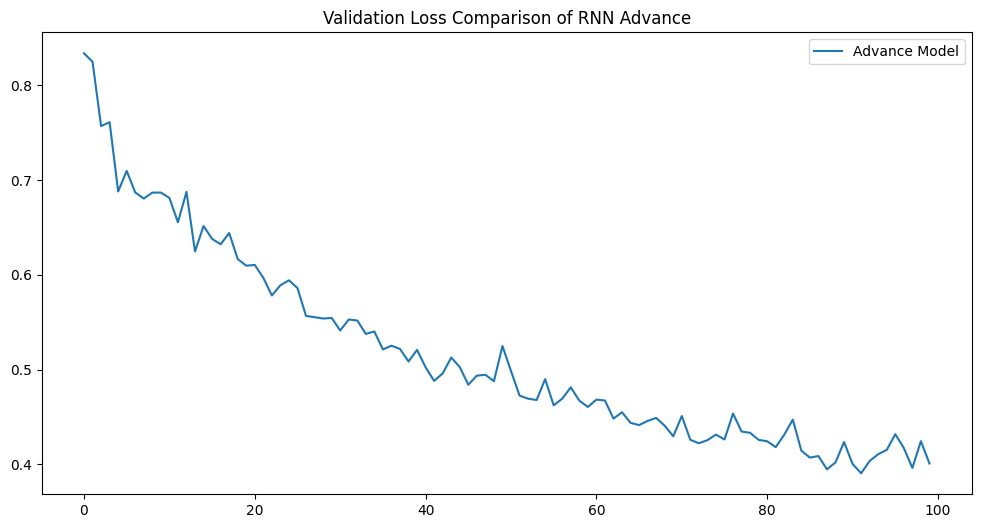

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_rnn.history['val_loss'], label='Advance Model')
plt.legend()
plt.title('Validation Loss Comparison of RNN Advance')
plt.show()

In [45]:
y_pred_scaled = model_RNN_advance.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_rnn_advance = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_rnn_advance = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_rnn_advance = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_rnn_advance} \n RMSE is {rmse_rnn_advance} \n MAPE is {mape_rnn_advance}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
R^2 is 0.5896058082580566 
 RMSE is 5493.08037443473 
 MAPE is 0.04185286909341812


In [46]:
result_data = {"Method":["RNN - Advance"],
               "R^2":[r2_rnn_advance],
               "RMSE":[rmse_rnn_advance],
               "MAPE":[mape_rnn_advance]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772
3,RNN - Simple,0.585882,5517.947082,0.043970
4,RNN - Normal,0.562197,5673.548801,0.044369
5,RNN - Advance,0.589606,5493.080374,0.041853


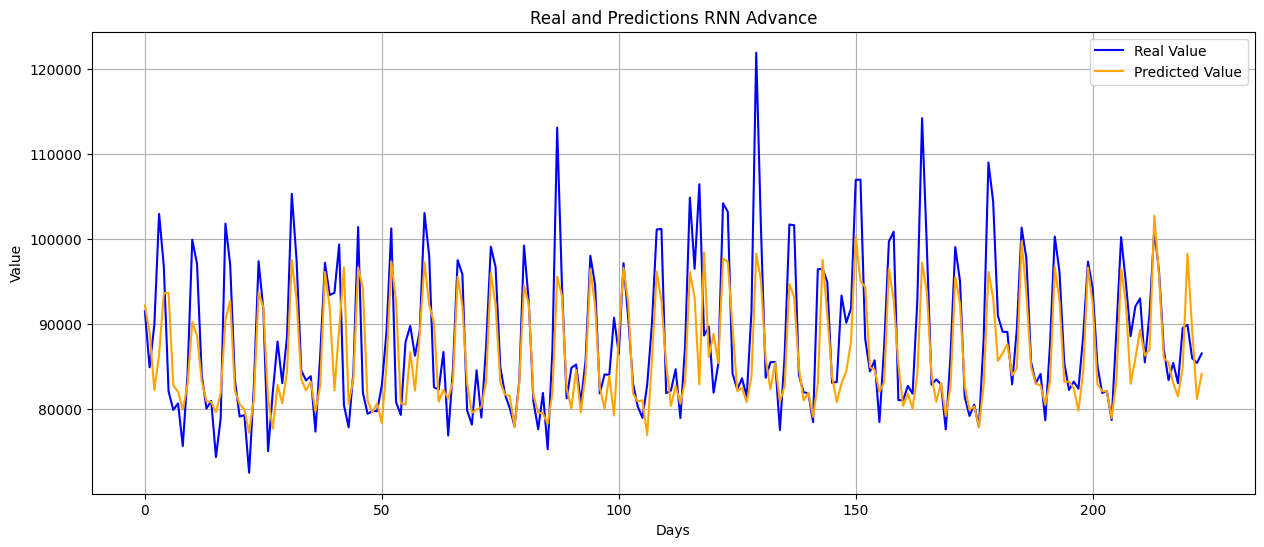

In [52]:
plt.figure(figsize=(15,6))
plt.plot(y_test, label='Real Value', color='blue')
plt.plot(y_pred_scaled, label='Predicted Value', color='orange')
plt.title('Real and Predictions RNN Advance')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# GRU

In [53]:
from tensorflow.keras.layers import GRU

In [54]:
model_GRU_simple = Sequential([
    GRU(32, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_GRU_simple.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

history_gru = model_GRU_simple.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7414 - mae: 0.6552 - val_loss: 0.9563 - val_mae: 0.8014
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0177 - mae: 0.6929 - val_loss: 0.9415 - val_mae: 0.7975
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8199 - mae: 0.6495 - val_loss: 0.9125 - val_mae: 0.7844
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8870 - mae: 0.6621 - val_loss: 0.8614 - val_mae: 0.7517
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6363 - mae: 0.5729 - val_loss: 0.7922 - val_mae: 0.7167
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5141 - mae: 0.5225 - val_loss: 0.7013 - val_mae: 0.6673
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6885 - mae: 0.5145 - val_loss: 0.6018 - val_mae: 0.6137
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6211 - mae: 0.4808 - val_loss: 0.5310 - val_mae: 0.5690
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5709 - mae: 0.

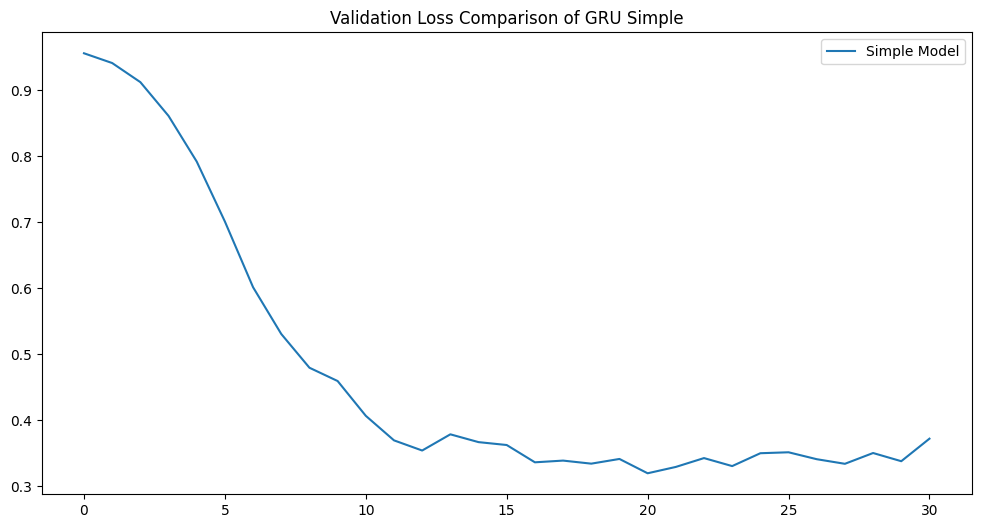

In [57]:
plt.figure(figsize=(12,6))
plt.plot(history_gru.history['val_loss'], label='Simple Model')
plt.legend()
plt.title('Validation Loss Comparison of GRU Simple')
plt.show()

In [59]:
y_pred_scaled = model_GRU_simple.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_gru_simple = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_gru_simple = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_gru_simple = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_gru_simple} \n RMSE is {rmse_gru_simple} \n MAPE is {mape_gru_simple}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R^2 is 0.48079389333724976 
 RMSE is 6178.530893343498 
 MAPE is 0.04870191961526871


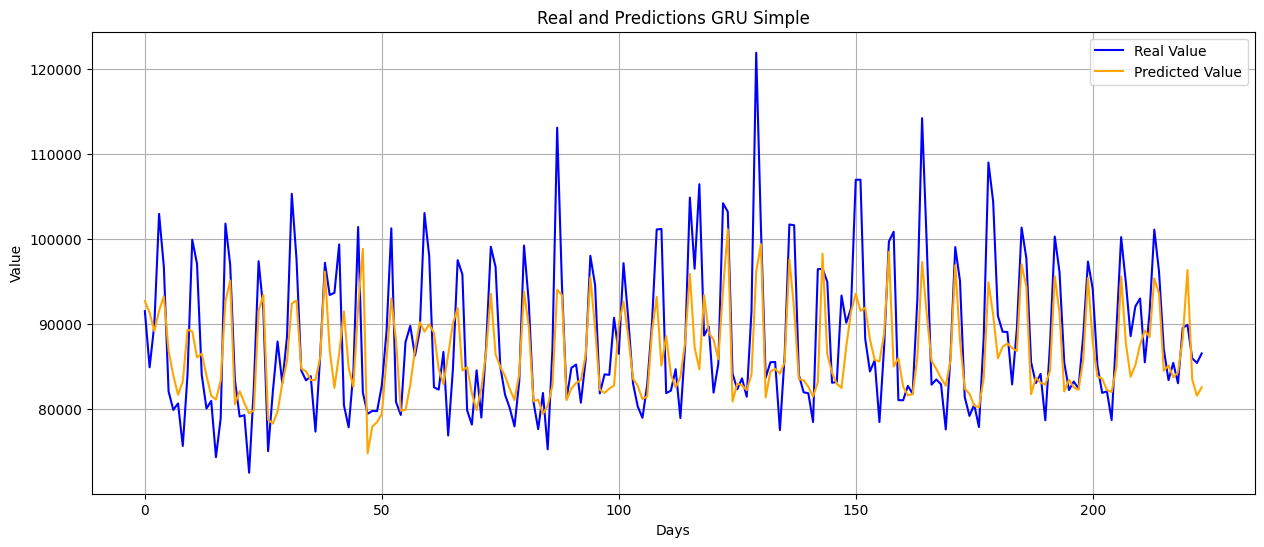

In [60]:
plt.figure(figsize=(15,6))
plt.plot(y_test, label='Real Value', color='blue')
plt.plot(y_pred_scaled, label='Predicted Value', color='orange')
plt.title('Real and Predictions GRU Simple')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
result_data = {"Method":["GRU - Simple"],
               "R^2":[r2_gru_simple],
               "RMSE":[rmse_gru_simple],
               "MAPE":[mape_gru_simple]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772
3,RNN - Simple,0.585882,5517.947082,0.043970
4,RNN - Normal,0.562197,5673.548801,0.044369
5,RNN - Advance,0.589606,5493.080374,0.041853
6,GRU - Simple,0.480794,6178.530893,0.048702


In [62]:
model_GRU_normal = Sequential([
    GRU(64, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_GRU_normal.compile(optimizer="adam", loss="mae")

history_gru = model_GRU_normal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

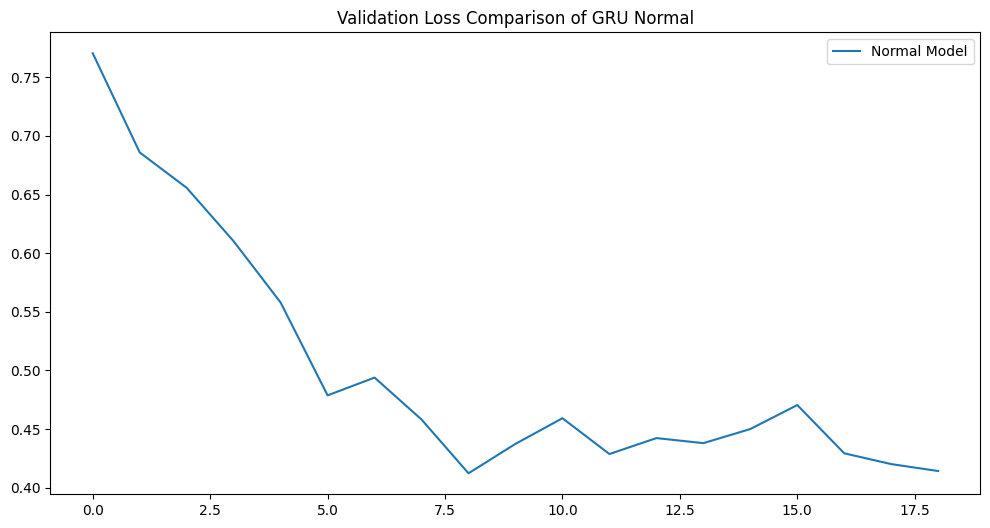

In [63]:
plt.figure(figsize=(12,6))
plt.plot(history_gru.history['val_loss'], label='Normal Model')
plt.legend()
plt.title('Validation Loss Comparison of GRU Normal')
plt.show()

In [64]:
y_pred_scaled = model_GRU_normal.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_gru_normal = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_gru_normal = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_gru_normal = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_gru_normal} \n RMSE is {rmse_gru_normal} \n MAPE is {mape_gru_normal}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
R^2 is 0.49933356046676636 
 RMSE is 6067.217813792414 
 MAPE is 0.04571624472737312


In [65]:
result_data = {"Method":["GRU - Normal"],
               "R^2":[r2_gru_normal],
               "RMSE":[rmse_gru_normal],
               "MAPE":[mape_gru_normal]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772
3,RNN - Simple,0.585882,5517.947082,0.043970
4,RNN - Normal,0.562197,5673.548801,0.044369
5,RNN - Advance,0.589606,5493.080374,0.041853
6,GRU - Simple,0.480794,6178.530893,0.048702
7,GRU - Normal,0.499334,6067.217814,0.045716


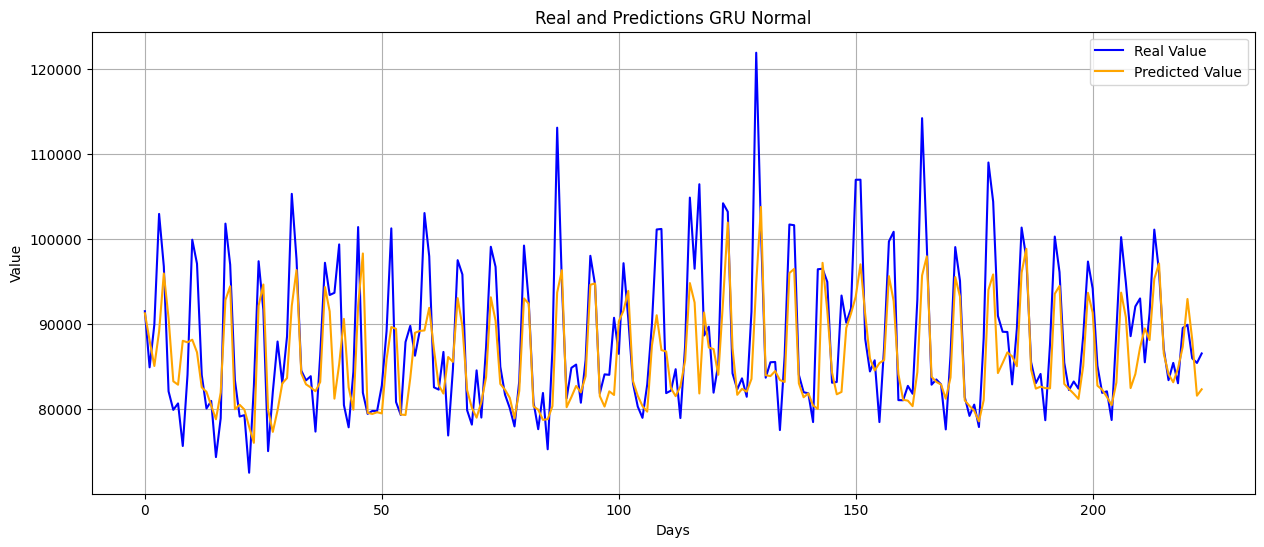

In [66]:
plt.figure(figsize=(15,6))
plt.plot(y_test, label='Real Value', color='blue')
plt.plot(y_pred_scaled, label='Predicted Value', color='orange')
plt.title('Real and Predictions GRU Normal')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
model_GRU_advance = Sequential([
    Bidirectional(GRU(128, return_sequences=True,
                      kernel_regularizer=l2(0.001),
                      recurrent_dropout=0.2),
                  input_shape=(X_train_scaled.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(GRU(64, return_sequences=False,
                      kernel_regularizer=l2(0.001),
                      recurrent_dropout=0.2)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(1)
])

In [68]:
model_GRU_advance.compile(optimizer="adam", loss="mae")

history_gru = model_GRU_advance.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

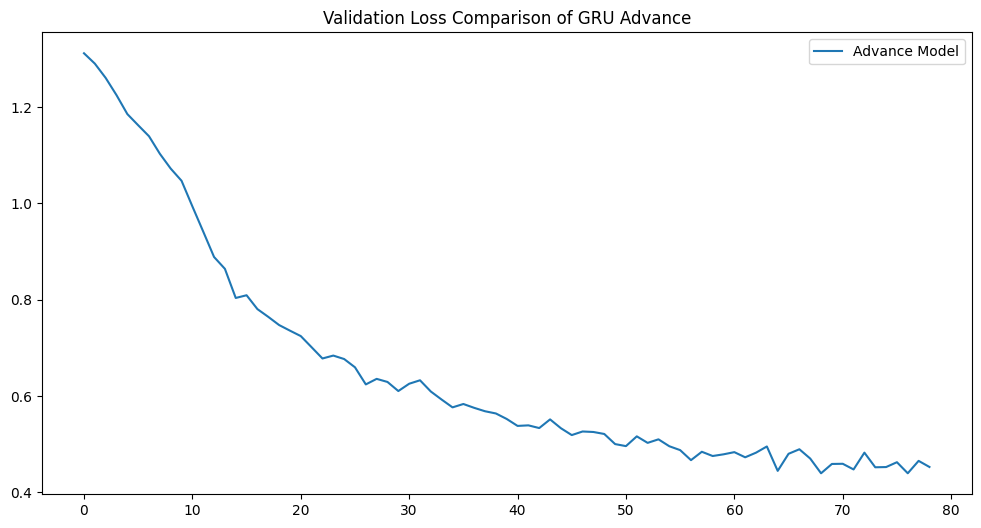

In [69]:
plt.figure(figsize=(12,6))
plt.plot(history_gru.history['val_loss'], label='Advance Model')
plt.legend()
plt.title('Validation Loss Comparison of GRU Advance')
plt.show()

In [70]:
y_pred_scaled = model_GRU_advance.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_gru_advance = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_gru_advance = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_gru_advance = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_gru_advance} \n RMSE is {rmse_gru_advance} \n MAPE is {mape_gru_advance}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
R^2 is 0.5460745096206665 
 RMSE is 5777.070018616703 
 MAPE is 0.044802792370319366


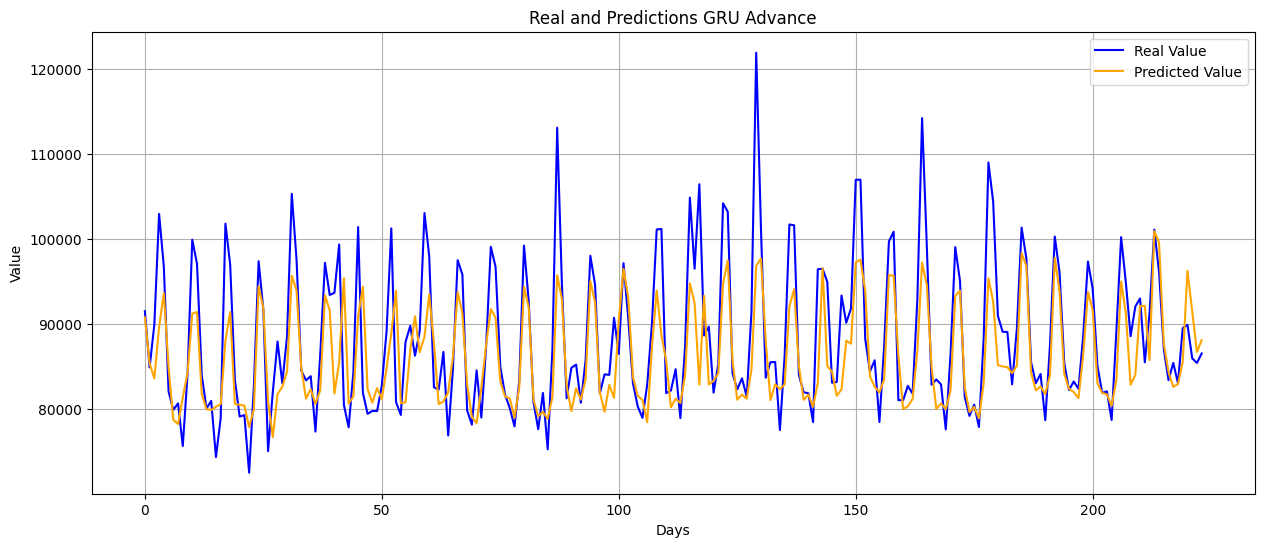

In [71]:
plt.figure(figsize=(15,6))
plt.plot(y_test, label='Real Value', color='blue')
plt.plot(y_pred_scaled, label='Predicted Value', color='orange')
plt.title('Real and Predictions GRU Advance')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
result_data = {"Method":["GRU - Advance"],
               "R^2":[r2_gru_advance],
               "RMSE":[rmse_gru_advance],
               "MAPE":[mape_gru_advance]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.501629,6053.291006,0.048875
1,LSTM - Normal,0.549879,5752.806967,0.044031
2,LSTM - Advance,0.565635,5651.228893,0.041772
3,RNN - Simple,0.585882,5517.947082,0.043970
4,RNN - Normal,0.562197,5673.548801,0.044369
5,RNN - Advance,0.589606,5493.080374,0.041853
6,GRU - Simple,0.480794,6178.530893,0.048702
7,GRU - Normal,0.499334,6067.217814,0.045716
8,GRU - Advance,0.546075,5777.070019,0.044803
